In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import cKDTree
from scipy.spatial.distance import cdist
from scipy.ndimage import gaussian_filter1d
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
import skimage as ski
from skimage.transform import resize

import warnings
warnings.filterwarnings('ignore')

#Set directories

working_dir = os.getcwd()

#Get mouse directory
mouse_demo_dir = os.path.dirname(working_dir)

#get demo directory
demo_dir = os.path.dirname(mouse_demo_dir)


import sys
sys.path.append(os.path.join(demo_dir,'PRGL_modules'))  # Add 'utils' to the path

from PRINGLE import *

In [28]:
#Import processed data
all_cells = pd.read_csv(os.path.join(mouse_demo_dir, 'Data', 'mouse_data_processing.csv'))


#Define midline channel
midline_channel = 'TBXT_norm'

# Import manual notochord labels
files = os.listdir(os.path.join(mouse_demo_dir, 'Data'))

noto_loc_files = [f for f in files if 'Noto' in f]

noto_starts = []

for idx, file in enumerate(noto_loc_files):
    temp = pd.read_csv(os.path.join(mouse_demo_dir, 'Data', file), sep='\t')
    #assign XYZ coordinates
    temp['X'] = temp['Centroid 0']
    temp['Y'] = temp['Centroid 1']
    temp['Z'] = temp['Centroid 2']

    file_parts = file.split('_')

    #Get embryo number
    temp['embryo'] = int(file_parts[1][-1])
    noto_starts.append(temp)

#Combine all the notochord cells
noto_starts = pd.concat(noto_starts)

## 1. Flatten embryo

#### Orient embryo to  major axis


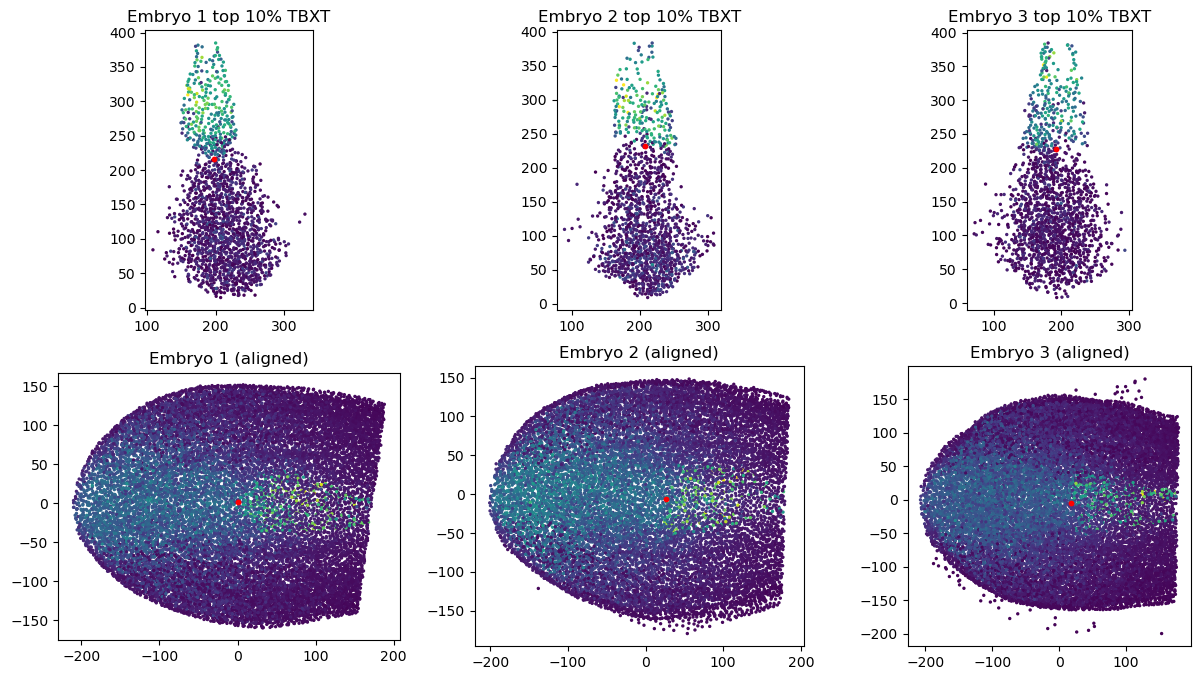

In [29]:

# rotate each embryo so that the major axis is aligned with the primitve streak (TBRA channel)
#Set axis
all_cells['X'] = all_cells['Centroid 0']
all_cells['Y'] = all_cells['Centroid 1']
all_cells['Z'] = all_cells['Centroid 2']


#plot the output
fig, ax = plt.subplots(2, 3, figsize=(15, 8))
for idx, embryo in enumerate(all_cells['embryo'].unique()):
    temp = all_cells.loc[all_cells['embryo'] == embryo]
    noto_point = noto_starts[noto_starts['embryo'] == embryo]

    top_T = temp.loc[temp[midline_channel] >np.percentile(temp[midline_channel], 90)]

    ax[0,idx].scatter(top_T['X'], top_T['Y'], c=top_T[midline_channel], cmap='viridis', s = 2)
    #plot manual notochord location
    ax[0,idx].scatter(noto_point['X'], noto_point['Y'], c='red', s = 10)

    ax[0,idx].set_title(f'Embryo {embryo} top 10% TBXT') 
    #set ratio of x and y axis to be the same
    ax[0,idx].set_aspect('equal', 'box')

    # set xy values
    tempXY = np.array(temp[['X', 'Y']])
    notoXY = np.array(noto_point[['X', 'Y']])
    top_TXY = np.array(top_T[['X', 'Y']])

    #Add the notochord to the temp data
    tempXY = np.vstack((tempXY, notoXY))

    # Align major axis using the top 10% of cells
    aligned_points, rotation_matrix = align_major_axis_2d(top_TXY, tempXY)

    # set alinged points centered at 0
    aligned_points = aligned_points - np.mean(aligned_points, axis=0)

    noto_aligned_point = aligned_points[-1]
    aligned_points = aligned_points[:-1]

    ax[1,idx].scatter(aligned_points[:, 0], aligned_points[:, 1], 
                      c=all_cells.loc[all_cells['embryo'] == embryo,midline_channel], 
                      cmap='viridis', s = 2)
    
    ax[1,idx].scatter(noto_aligned_point[0], noto_aligned_point[1], c='red', s = 10)
    ax[1,idx].set_title(f'Embryo {embryo} (aligned)')
    ax[1,idx].set_aspect('equal', 'box')

    #put back into main dataframe per embryo
    all_cells.loc[all_cells['embryo'] == embryo, 'Oriented_X'] = aligned_points[:, 0]
    all_cells.loc[all_cells['embryo'] == embryo, 'Oriented_Y'] = aligned_points[:, 1]

    #put back into notochord dataframe
    noto_starts.loc[noto_starts['embryo'] == embryo, 'Oriented_X'] = noto_aligned_point[0]
    noto_starts.loc[noto_starts['embryo'] == embryo, 'Oriented_Y'] = noto_aligned_point[1]


### Smooth the TBRA signal by neighbourhood averaging

Iteration round: 0
Iteration round: 1
Iteration round: 2
Iteration round: 3
Iteration round: 4
Iteration round: 0
Iteration round: 1
Iteration round: 2
Iteration round: 3
Iteration round: 4
Iteration round: 0
Iteration round: 1
Iteration round: 2
Iteration round: 3
Iteration round: 4


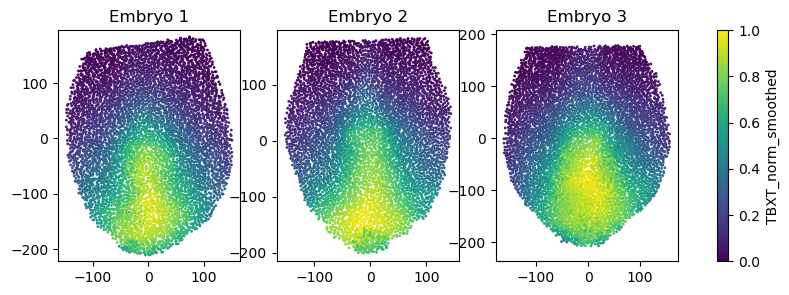

In [30]:
#loop through each embryo
for idx, embryo in enumerate(all_cells['embryo'].unique()):
    epi_nuc = all_cells[(all_cells['Epiblast'] >= 0) & (all_cells['embryo'] == embryo)]
    index = epi_nuc.index
    #reset index
    epi_nuc = epi_nuc.reset_index(drop=True)

    # Smooth both XYZ coordinates and signal
    smoothed_props, smoothed_signal = smooth_signal_in_point_cloud(points = epi_nuc[['Z', 'X', 'Y']].values, 
                                                                     signal = epi_nuc[midline_channel], 
                                                                     iterations=5, # Number of iterations for smoothing
                                                                     radius=12) # Radius of smoothing in microns

    all_cells.loc[index, midline_channel + '_smoothed'] = smoothed_signal

smth_midline_channel = midline_channel + '_smoothed'

#Plot output
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
for i, embryo in enumerate(all_cells['embryo'].unique()):
    epi_nuc = all_cells[(all_cells['Epiblast'] >= 0) & (all_cells['embryo'] == embryo)]
    ax[i].scatter(epi_nuc['Oriented_Y'], epi_nuc['Oriented_X'], c=epi_nuc[smth_midline_channel], s=1, cmap='viridis')
    ax[i].set_title(f'Embryo {embryo}')
    ax[i].axis('equal')
plt.colorbar(ax[0].scatter([], [], c=[], cmap='viridis', s=1), ax=ax, label= smth_midline_channel)
plt.show()

#### Flatten anterior-posterior curvature

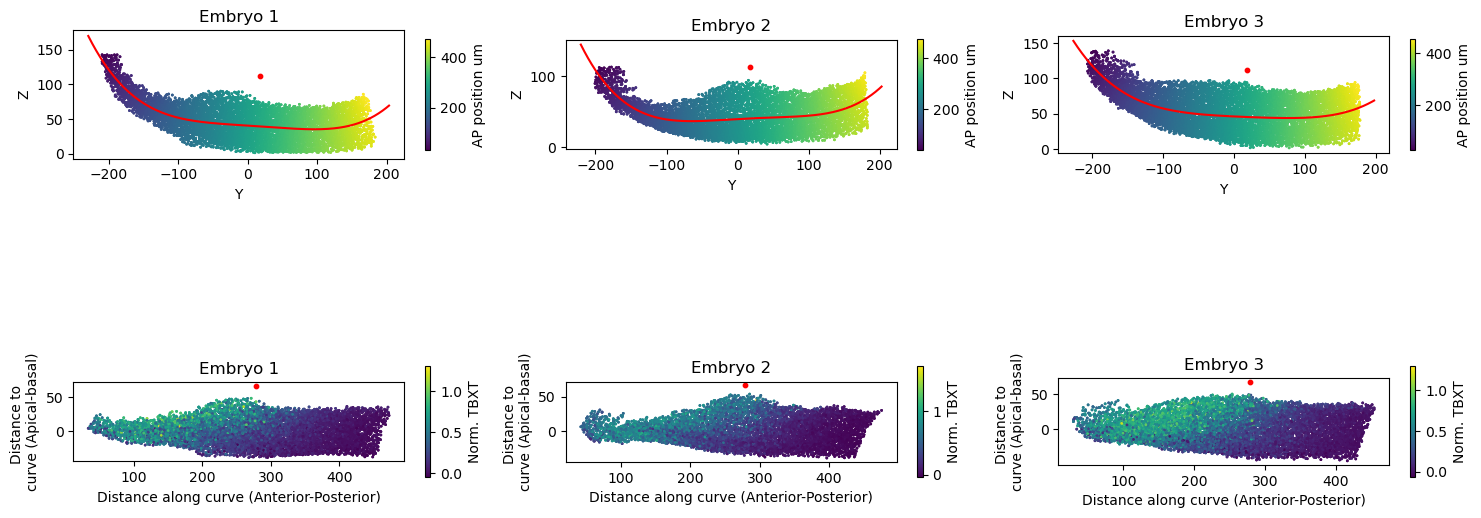

In [31]:
embryo_curves = []

for idx, embryo in enumerate(all_cells['embryo'].unique()):
    # Isolate epiblast cells per embryo
    epi_nuc = all_cells[(all_cells['embryo'] == embryo) & (all_cells['Epiblast'] >= 0)]
    
    # Generate the curve
    embryo_curve, distance_along_curve, arg_min, min_distance = generate_embryo_curve(epi_nuc,
                                                                                      x_col='Oriented_X',
                                                                                      z_col='Z',
                                                                                      y_col='Oriented_Y')
    
    # Assign distances to the cells
    all_cells.loc[epi_nuc.index, 'AP_position'] = distance_along_curve[arg_min]
    all_cells.loc[epi_nuc.index, 'Apical_basal_position'] = min_distance

    #Add embryo curve id
    embryo_curve['embryo'] = embryo

    #Append to list
    embryo_curves.append(embryo_curve)

    #------------------------------------------------

    #Also perform the same for the single notochord point
    noto_cells = noto_starts[noto_starts['embryo'] == embryo]
    noto_distance = cdist(noto_cells[['Z', 'Oriented_X']], embryo_curve[['Z', 'Oriented_X']])
    noto_arg_min = np.argmin(noto_distance, axis=1)
    noto_min_distance = np.min(noto_distance, axis=1)

    # Make distance negative if the point is below the curve
    noto_below_curve = noto_cells['Z'].values < embryo_curve['Z'].values[noto_arg_min]
    if noto_below_curve.any():
        noto_min_distance *= -1

    # Assign distances to the cell from original dataframe
    noto_cells['AP_position'] = distance_along_curve[noto_arg_min]
    noto_cells['Apical_basal_position'] = noto_min_distance

    noto_starts.loc[noto_starts['embryo'] == embryo, 'AP_position'] = noto_cells['AP_position'].values
    noto_starts.loc[noto_starts['embryo'] == embryo, 'Apical_basal_position'] = noto_cells['Apical_basal_position'].values


fig, ax = plt.subplots(2, len(all_cells['embryo'].unique()), figsize=(15, 8))

for idx, embryo in enumerate(all_cells['embryo'].unique()):
    embryo_cells = all_cells[(all_cells['embryo'] == embryo) & (all_cells['Epiblast'] >= 0)]

    dense_x = embryo_curves[idx]['Oriented_X']
    dense_z = embryo_curves[idx]['Z']
    # Plot
    ax[0, idx].scatter(embryo_cells['Oriented_X'], embryo_cells['Z'], c=embryo_cells['AP_position'], s=1, cmap='viridis')
    ax[0, idx].plot(dense_x, dense_z,  c='red')
    #plot the notochord
    ax[0, idx].scatter(noto_cells['Oriented_X'], noto_cells['Z'], c='red', s=10)
    ax[0, idx].set_title(f'Embryo {embryo}')
    ax[0, idx].set_aspect('equal')
    ax[0, idx].set_xlabel('Y')
    ax[0, idx].set_ylabel('Z')
    sc = ax[0, idx].scatter(embryo_cells['Oriented_X'], embryo_cells['Z'], c=embryo_cells['AP_position'], s=1, cmap='viridis')
    cbar = plt.colorbar(sc, ax=ax[0, idx], shrink=0.25)
    cbar.set_label('AP position um')  # Add your custom label here

    ax[1, idx].scatter(embryo_cells['AP_position'], embryo_cells['Apical_basal_position'], c=embryo_cells['TBXT'], s=1, cmap='viridis')
    ax[1, idx].scatter(noto_cells['AP_position'], noto_cells['Apical_basal_position'], c='red', s = 10)
    ax[1, idx].set_title(f'Embryo {embryo}')
    ax[1, idx].set_xlabel('Distance along curve (Anterior-Posterior)')
    ax[1, idx].set_ylabel('Distance to \ncurve (Apical-basal)')
    ax[1, idx].set_aspect('equal')

    #plot colorbar for TBXT
    sc = ax[1, idx].scatter(embryo_cells['AP_position'], embryo_cells['Apical_basal_position'], c=embryo_cells['TBXT_norm'], s=1, cmap='viridis')
    cbar = plt.colorbar(sc, ax=ax[1, idx], shrink=0.25)
    cbar.set_label('Norm. TBXT')  # Add your custom label here


plt.tight_layout()
plt.show()


#### Find midline

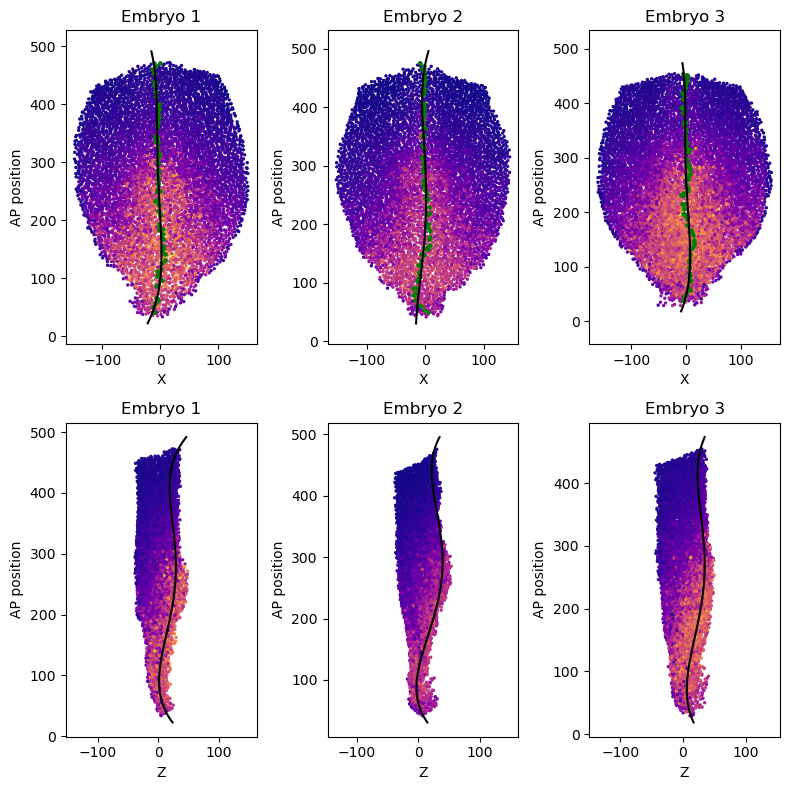

In [32]:
#Set columns
x_col='Oriented_Y'
y_col='AP_position'
z_col='Apical_basal_position'

smoothed_line_all = []
original_midpoints = []

for idx, embryo in enumerate(all_cells['embryo'].unique()):
    # Isolate epiblast cells per embryo
    epi_nuc = all_cells[(all_cells['embryo'] == embryo) & (all_cells['Epiblast'] >= 0)]

    smoothed_line, centroids = find_midline(epi_nuc, 
                                      smth_midline_channel,
                                       x_col=x_col, 
                                       y_col=y_col, 
                                       z_col=z_col,
                                       percentile_threshold=0.8,
                                       lim_dist=10,
                                       window_size=10)
    smoothed_line['embryo'] = embryo
    smoothed_line_all.append(smoothed_line)

    centroids = pd.DataFrame(centroids, columns=[z_col, y_col, x_col])
    centroids['embryo'] = embryo
    original_midpoints.append(centroids)



#Plot original midline points and smoothed line in XY and XZ

fig, ax = plt.subplots(2, len(all_cells['embryo'].unique()), figsize=(8, 8))

for idx, embryo in enumerate(all_cells['embryo'].unique()):
    epi_nuc = all_cells[(all_cells['embryo'] == embryo) & (all_cells['Epiblast'] >= 0)]
    smoothed_line = smoothed_line_all[idx]
    centroids = original_midpoints[idx]

    ax[0, idx].scatter(epi_nuc[x_col], epi_nuc[y_col], c=epi_nuc['TBXT_norm'], s=2, cmap='plasma')  
    ax[0, idx].scatter(centroids[x_col], centroids[y_col], c='g', s=5)
    ax[0, idx].plot(smoothed_line[x_col], smoothed_line[y_col], c='black')
    ax[0, idx].axis('equal')
    ax[0, idx].set_title(f'Embryo {embryo}')
    ax[0, idx].set_xlabel('X')
    ax[0, idx].set_ylabel('AP position')

    ax[1, idx].scatter(epi_nuc[z_col], epi_nuc[y_col], c=epi_nuc['TBXT_norm'], s=2, cmap='plasma')
    ax[1, idx].plot(smoothed_line[z_col], smoothed_line[y_col], c='black')
    ax[1, idx].axis('equal')
    ax[1, idx].set_title(f'Embryo {embryo}')
    ax[1, idx].set_xlabel('Z')
    ax[1, idx].set_ylabel('AP position')

plt.tight_layout()
plt.show()

smoothed_line_all = pd.concat(smoothed_line_all)
original_midpoints = pd.concat(original_midpoints)

#### Find left-right position from midline along epithelia curve

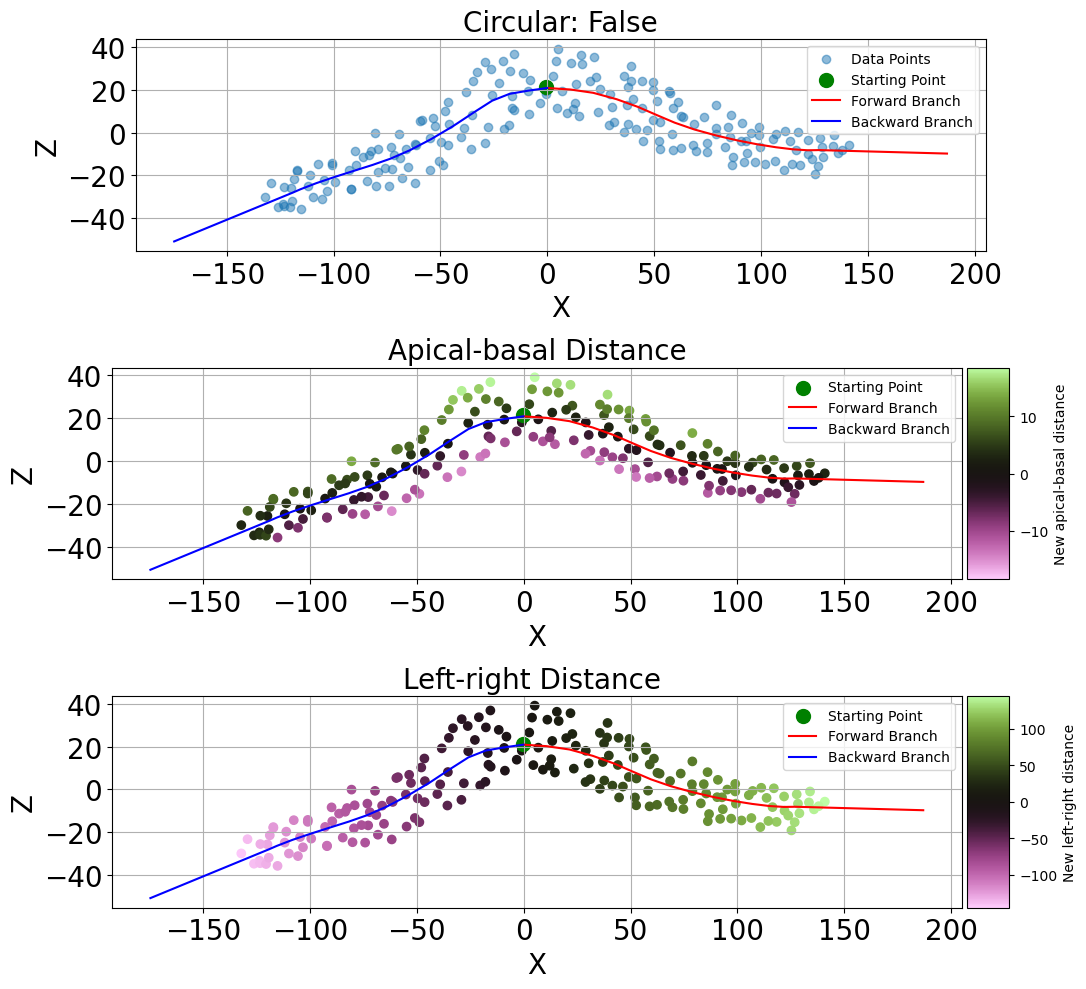

In [33]:
# Test on one slice to optimise parameters

x_col = 'AP_position'
y_col = 'Oriented_Y'
z_col = 'Apical_basal_position'

#Define the LR flattening class with parameters
LR_flattening_c = LR_flattening(
    h=15, # The distance considered for the local smoother
    step_size=10, # The step size for growing the line
    max_iter=100, # The maximum number of iterations in growing the line 
    tol=0.0001, # The tolerance in variation for stopping the growing
    start_point='custom', # We are providing a custom starting point
    z_col = z_col, # The column with the z-coordinates
    x_col = x_col, # The column with the x-coordinates
    y_col = y_col, # The column with the y-coordinates
    smooth_h=2 # The smoothing parameter for the line after 
    )

# Create and fit the model
embryo = 1
epi_nuc = all_cells[(all_cells['Epiblast'] >= 0) & (all_cells['embryo'] == embryo)]
#remove inifinities
epi_nuc = epi_nuc.replace([np.inf, -np.inf], np.nan)
epi_nuc = epi_nuc.dropna(subset=[z_col, y_col])

smoothed_line = smoothed_line_all[smoothed_line_all['embryo'] == embryo]
smoothed_line = smoothed_line.replace([np.inf, -np.inf], np.nan)
smoothed_line = smoothed_line.dropna(subset=[z_col, y_col])

#Use built in function to test slice
curve, distance_analysis = LR_flattening_c.test_slice(epi_nuc, 
                                          smoothed_line, 200,10)

Processing Embryo 1
Processing Embryo 2
Processing Embryo 3
Average time per embryo: 8.90 seconds


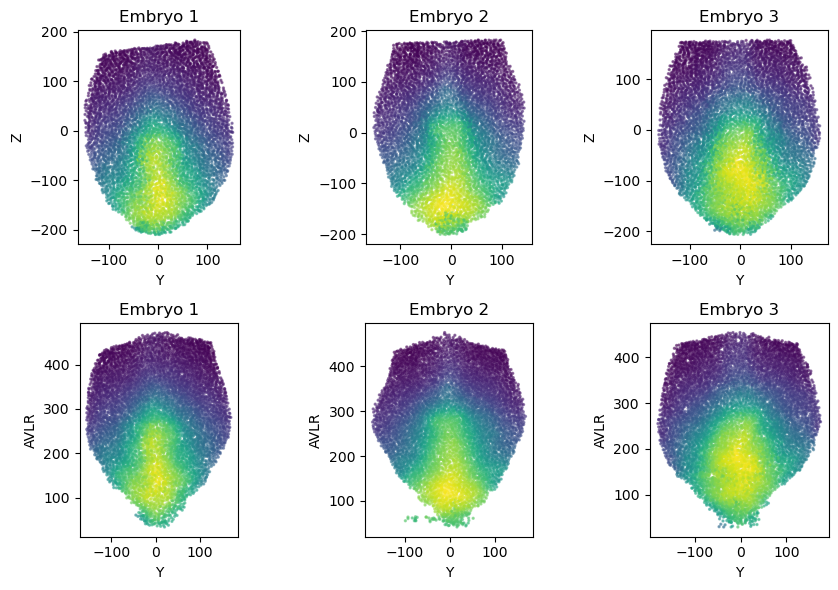

In [35]:
# Flatten the whole embryo - faster version with optimized grouping

x_col = 'AP_position'
y_col = 'Oriented_Y'
z_col = 'Apical_basal_position'


# Define binning parameters
start_point_iter = epi_nuc[x_col].min()
end_point_iter = epi_nuc[x_col].max()
step = 12 # don't make this too small as too few cells in each bin will cause issues
iterations = np.arange(start_point_iter, end_point_iter + step, step)
bin_edges = np.append(iterations, iterations[-1] + step)

#Record time per embryo
time_per_embryo = []

# Iterate over each unique embryo
for idx, embryo in enumerate(all_cells['embryo'].unique()):
    # Initiate timer
    start_time = time.time()
    #
    print(f"Processing Embryo {embryo}")

    # Filter data for current embryo and select relevant columns
    epi_nuc = all_cells[(all_cells['embryo'] == embryo) & (all_cells['Epiblast'] >= 0)]
    smoothed_line = smoothed_line_all[smoothed_line_all['embryo'] == embryo]

    # Assign unique IDs and track original index
    epi_nuc['original_index'] = epi_nuc.index
    epi_nuc['new_ID'] = np.arange(len(epi_nuc))
    unique_ids = np.sort(epi_nuc['new_ID'].unique())

    # Select key columns
    epi_nuc = epi_nuc[[z_col, y_col, x_col, 'new_ID', 'original_index']]

    # Apply binning into discrete sections
    epi_nuc['section'] = np.digitize(epi_nuc[x_col], bins=bin_edges) - 1
    smoothed_line['section'] = np.digitize(smoothed_line[x_col], bins=bin_edges) - 1

    # Initialize accumulated data array
    accumulated_array = np.zeros((len(unique_ids), 3))

    # Group data by sections
    grouped_epi = epi_nuc.groupby('section')
    grouped_smoothed = smoothed_line.groupby('section')

    # Initialize columns for analysis
    epi_nuc['AVLR'] = 0
    epi_nuc['New_Z'] = 0

    # Process each section
    no_iterations = len(grouped_epi)
    for counter, (section, sub_slice) in enumerate(grouped_epi, start=1):
        print(f"Section {counter}/{no_iterations}", end='\r')

        # Skip if section not in smoothed data
        if section not in grouped_smoothed.groups:
            continue

        sub_smoothed_line = grouped_smoothed.get_group(section)
        start_point = np.array([sub_smoothed_line[z_col].mean(), sub_smoothed_line[y_col].mean()])

        # Fit LR_flattening class
        LR_flattening_c = LR_flattening(h=10, step_size=10, max_iter=100, tol=0.0001, start_point='custom', k=2,
                      z_col=z_col, x_col=x_col, y_col=y_col, smooth_h=2)
        
        # Find LR positions
        curve, distance_analysis = LR_flattening_c.fit_with_branches(sub_slice[[z_col, y_col]], start_point=start_point)

        # Accumulate results
        ids_in_section = sub_slice['new_ID'].values
        accumulated_array[ids_in_section, 0] += distance_analysis['Dist_from_midline'].values
        accumulated_array[ids_in_section, 1] += distance_analysis['intersection_distance'].values
        accumulated_array[ids_in_section, 2] += 1

    # Finalize analysis columns
    epi_nuc['AVLR'] = accumulated_array[:, 0] / accumulated_array[:, 2]
    epi_nuc['New_Z'] = accumulated_array[:, 1] / accumulated_array[:, 2]

    # Map results back to original dataframe
    all_cells.loc[epi_nuc['original_index'], 'AVLR'] = epi_nuc['AVLR'].values
    all_cells.loc[epi_nuc['original_index'], 'New_Z'] = epi_nuc['New_Z'].values

    # Record time
    time_per_embryo.append(time.time() - start_time)


print(f"Average time per embryo: {np.mean(time_per_embryo):.2f} seconds")
# Get number of embryos
num_embryos = len(all_cells['embryo'].unique())

# Create plots
fig, ax = plt.subplots(2, num_embryos, figsize=(3 * num_embryos, 6))

# Visualize results
for idx, embryo in enumerate(all_cells['embryo'].unique()):
    temp = all_cells[(all_cells['embryo'] == embryo) & (all_cells['Epiblast'] >= 0)]
    ax[0, idx].scatter(temp['Oriented_Y'], temp['Oriented_X'], c=temp[smth_midline_channel], alpha=0.5, s=2)
    ax[0, idx].set_title(f'Embryo {embryo}')
    ax[0, idx].set_xlabel('Y')
    ax[0, idx].set_ylabel('Z')
    ax[0, idx].set_aspect('equal', adjustable='box')

    temp = all_cells[all_cells['embryo'] == embryo]
    ax[1, idx].scatter(temp['AVLR'], temp[x_col], c=temp[smth_midline_channel], alpha=0.5, s=2)
    ax[1, idx].set_title(f'Embryo {embryo}')
    ax[1, idx].set_xlabel('Y')
    ax[1, idx].set_ylabel('AVLR')
    ax[1, idx].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()


Processing Embryo 1
Processing Embryo 2
Processing Embryo 3
Average time per embryo: 23.42 seconds


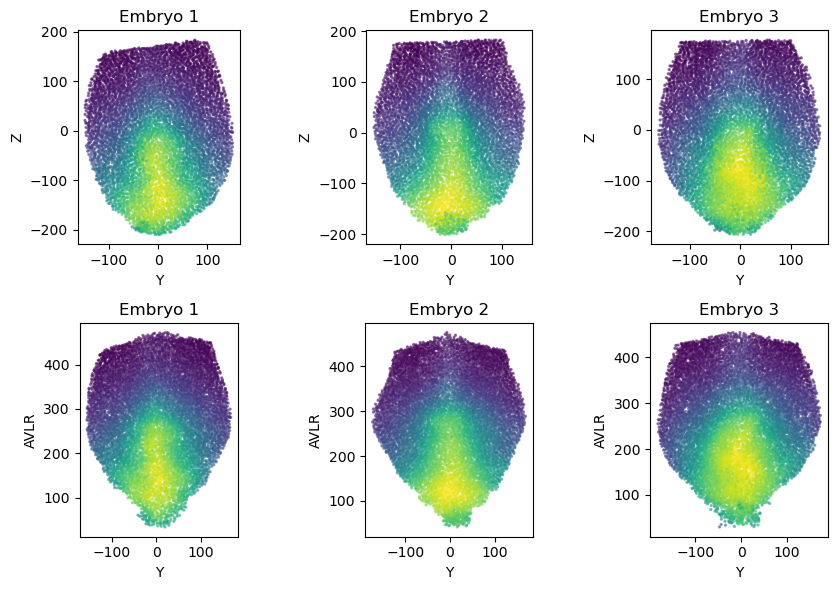

In [46]:
# Slightly slower version with sliding window to increase stability and smoother edges
# Would recommend use this for smaller embryos that require precision, for large embryos like chick this can be not efficient

x_col = 'AP_position'
y_col = 'Oriented_Y'
z_col = 'Apical_basal_position'

# Define binning parameters
start_point_iter = epi_nuc[x_col].min()
end_point_iter = epi_nuc[x_col].max()
step = 8
window = 20
iterations = np.arange(start_point_iter, end_point_iter + step, step)
bin_edges = np.append(iterations, iterations[-1] + step)


#Record time per embryo
time_per_embryo = []

# Iterate over each unique embryo
for idx, embryo in enumerate(all_cells['embryo'].unique()):
    # Initiate timer
    start_time = time.time()

    print(f"Processing Embryo {embryo}")
    # Filter data for current embryo and select relevant columns
    epi_nuc = all_cells[(all_cells['embryo'] == embryo) & (all_cells['Epiblast'] >= 0)]
    smoothed_line = smoothed_line_all[smoothed_line_all['embryo'] == embryo]

    # Assign unique IDs and track original index
    epi_nuc['original_index'] = epi_nuc.index
    epi_nuc['new_ID'] = np.arange(len(epi_nuc))
    unique_ids = np.sort(epi_nuc['new_ID'].unique())

    # initialize accumulated data array
    accumulated_array = np.zeros((len(unique_ids), 3))

    # Select key columns
    epi_nuc = epi_nuc[[z_col, y_col, x_col, 'new_ID', 'original_index']]

    # Initialize columns for analysis
    epi_nuc['AVLR'] = 0
    epi_nuc['New_Z'] = 0

    # Loop through with sliding window instead of sections
    no_iterations = len(iterations)
    for counter, section in enumerate(iterations):
        epi_sub = epi_nuc[(epi_nuc[x_col] > section) & (epi_nuc[x_col] < (section + window))]
        smoothed_sub = smoothed_line[(smoothed_line[x_col] > (section - window)) & (smoothed_line[x_col] < (section + window))]

        # Skip if no data in section
        if epi_sub.empty or smoothed_sub.empty:
            continue
        else:
            print(f"Section {counter}/{no_iterations}", end='\r')

        # Rebuild KDTree for the subset of the data
        epi_tree = cKDTree(epi_sub[[z_col, y_col]].values)

        # Find closest point to smoothed line start
        start_point = np.array([smoothed_sub[z_col].mean(), smoothed_sub[y_col].mean()])

        # Fit LR_flattening model
        LR_flattening_c = LR_flattening(h=9, step_size=9, max_iter=200, tol=0.0001, start_point='custom', k=2,
                      z_col=z_col, x_col=x_col, y_col=y_col, smooth_h=2)
        
        curve, distance_analysis = LR_flattening_c.fit_with_branches(epi_sub[[z_col, y_col]], start_point=start_point)

        # Accumulate results
        ids_in_section = epi_sub['new_ID'].values
        accumulated_array[ids_in_section, 0] += distance_analysis['Dist_from_midline'].values
        accumulated_array[ids_in_section, 1] += distance_analysis['intersection_distance'].values
        accumulated_array[ids_in_section, 2] += 1

    # Finalize analysis columns and find averages from window
    epi_nuc['AVLR'] = accumulated_array[:, 0] / accumulated_array[:, 2]
    epi_nuc['New_Z'] = accumulated_array[:, 1] / accumulated_array[:, 2]


    # Map results back to original dataframe
    all_cells.loc[epi_nuc['original_index'], 'AVLR'] = epi_nuc['AVLR'].values
    all_cells.loc[epi_nuc['original_index'], 'New_Z'] = epi_nuc['New_Z'].values
    # Record time
    time_per_embryo.append(time.time() - start_time)


print(f"Average time per embryo: {np.mean(time_per_embryo):.2f} seconds")

# Create plots
fig, ax = plt.subplots(2, num_embryos, figsize=(3 * num_embryos, 6))

# Visualize results
for idx, embryo in enumerate(all_cells['embryo'].unique()):
    temp = all_cells[(all_cells['embryo'] == embryo) & (all_cells['Epiblast'] >= 0)]
    ax[0, idx].scatter(temp['Oriented_Y'], temp['Oriented_X'], c=temp[smth_midline_channel], alpha=0.5, s=2)
    ax[0, idx].set_title(f'Embryo {embryo}')
    ax[0, idx].set_xlabel('Y')
    ax[0, idx].set_ylabel('Z')
    ax[0, idx].set_aspect('equal', adjustable='box')

    temp = all_cells[all_cells['embryo'] == embryo]
    ax[1, idx].scatter(temp['AVLR'], temp[x_col], c=temp[smth_midline_channel], alpha=0.5, s=2)
    ax[1, idx].set_title(f'Embryo {embryo}')
    ax[1, idx].set_xlabel('Y')
    ax[1, idx].set_ylabel('AVLR')
    ax[1, idx].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

## 2. Normalise Embryos together

#### Normlise A-P positions to notochord and scale to average primitive streak length

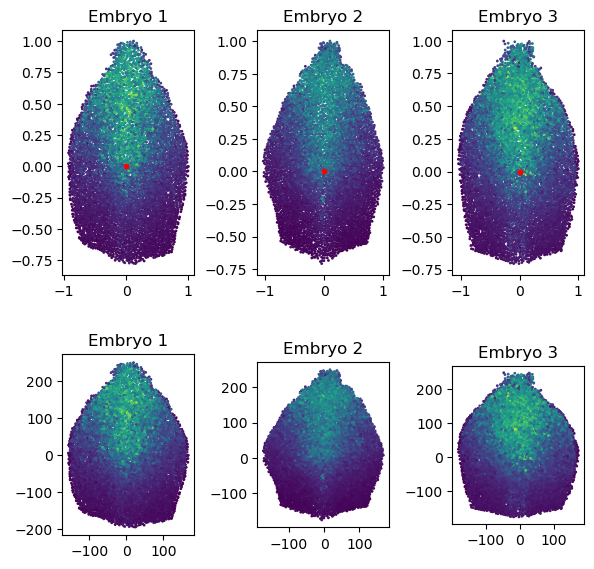

In [47]:
#Set nomrlised AP position from notochord to the end of the embryo
PS_lengths = []
for idx, embryo in enumerate(all_cells['embryo'].unique()):
    epi_nuc = all_cells[(all_cells['Epiblast'] >= 0) & (all_cells['embryo'] == embryo)]

    noto_point = noto_starts[noto_starts['embryo'] == embryo]

    # Normalise AP position
    epi_nuc['Rel_AP_position'] = (epi_nuc['AP_position'] -  epi_nuc['AP_position'].min())/ (noto_point['AP_position'].values - epi_nuc['AP_position'].min())
    all_cells.loc[(all_cells['Epiblast'] >= 0) & (all_cells['embryo'] == embryo), 'Rel_AP_position'] = epi_nuc['Rel_AP_position']

    PS_lengths.append(noto_point['AP_position'].values - epi_nuc['AP_position'].min())

#Flip the AP position so posterior is facing upwards
all_cells['Rel_AP_position'] = 1 - all_cells['Rel_AP_position']

#Find the mean length of the primitive streak
mean_PS_length = np.mean(PS_lengths)

#Set scaled AP position
all_cells['Scaled_Rel_AP_position'] = all_cells['Rel_AP_position'] * mean_PS_length

fig, ax = plt.subplots(2, len(all_cells['embryo'].unique()), figsize=(6, 6))
for idx, embryo in enumerate(all_cells['embryo'].unique()):
    epi_nuc = all_cells[(all_cells['Epiblast'] >= 0) & (all_cells['embryo'] == embryo)]


    ax[0,idx].scatter(epi_nuc['AVLR']/epi_nuc['AVLR'].max(), epi_nuc['Rel_AP_position'],  c=epi_nuc['TBXT_norm'], s=1, cmap='viridis')
    ax[0,idx].set_title(f'Embryo {embryo}')
    ax[0,idx].scatter(0, 0, c='red', s=10)
    # ax[1,idx].set_aspect('equal')
    # ax[idx].axis('equal')

    ax[1,idx].scatter(epi_nuc['AVLR'], epi_nuc['Scaled_Rel_AP_position'],  c=epi_nuc['TBXT_norm'], s=1, cmap='viridis')
    ax[1,idx].set_title(f'Embryo {embryo}')
    ax[1,idx].set_aspect('equal')

plt.tight_layout()
plt.show()




#### Find relative positions from midline to epithelia edge, then scale to average width

Embryo 1
Embryo 2
Embryo 3


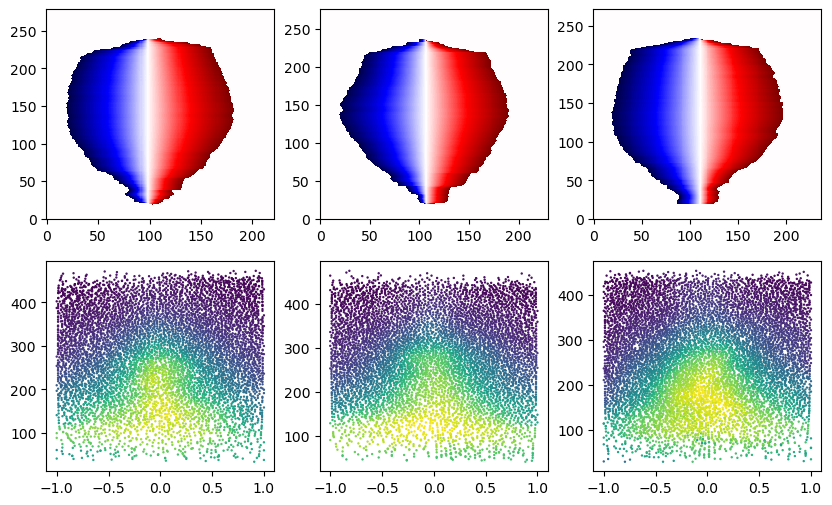

In [48]:
# Find the relative map

#Find relaitve position of each cell from the midline to the edge per AP positions
# Chick epiblast inference isn't perfect, so we'll smooth the edges location a bit

fig, ax = plt.subplots(2, len(all_cells['embryo'].unique()), figsize=(10, 6))


x_col = 'AP_position'
y_col = 'Oriented_Y'
z_col = 'Apical_basal_distance'


downscaler = 2
for idx, embryo in enumerate(all_cells['embryo'].unique()):
    print(f"Embryo {embryo}")
    epi_nuc = all_cells[(all_cells['embryo'] == embryo) & (all_cells['Epiblast'] >= 0)]
    indexes = epi_nuc.index
    epi_nuc['original_index'] = indexes
    #remove cells with no neighbors

    # Normalize AVLR and Oriented_X to positive values to fill in image
    midline = epi_nuc['AVLR'].min()
    epi_nuc['AVLR_pos'] = epi_nuc['AVLR'] - midline
    epi_nuc[x_col+'_pos'] = epi_nuc[x_col] - epi_nuc[x_col].min()

    # Remove NaNs together to avoid mismatched lengths
    epi_nuc_clean = epi_nuc.dropna(subset=['AVLR_pos', x_col+'_pos'])

    # Convert to image coordinates (add 50 pixel buffer)

    pix_buffer = 20
    LR_coords = ((epi_nuc_clean['AVLR_pos'] / downscaler).astype(int).values + pix_buffer).astype(int)
    X_coords = ((epi_nuc_clean[x_col+'_pos'] / downscaler).astype(int).values+ pix_buffer).astype(int)

    # Create a blank image
    img = np.zeros((LR_coords.max() + int(pix_buffer*2), X_coords.max() + int(pix_buffer*2)))

    # Fill in the image for outline mask
    img[LR_coords, X_coords] = 1

    # Fill in small gaps in the mask
    img_filled = ski.morphology.binary_closing(img, ski.morphology.disk(3))

    #Smooth the img then otsu threshold to find outline
    img_filled = ski.filters.gaussian(img_filled, sigma = 1, mode = 'reflect')
    img_filled = img_filled > ski.filters.threshold_li(img_filled)

    # Midline converted into image coordinates
    midline_img = (abs(midline) / downscaler) + pix_buffer

    # Initialize the relative map and absolute map
    rel_map = np.zeros_like(img_filled, dtype=float)
    abs_map = np.zeros_like(img_filled, dtype=float)

    # Loop through each X column in image
    for x in range(img_filled.shape[1]):
        column = img_filled[:, x]
        
        # Skip empty columns
        if column.sum() == 0:
            continue
        
        # Top and bottom outlines
        top = np.argmax(column)
        bottom = len(column) - np.argmax(column[::-1]) - 1

        # Relative positions  and abs (in downscaled pixels) from midline
        for y in range(top, bottom + 1):
            if y < midline_img:
                rel_map[y, x] = (y - midline_img) / (midline_img - top) if midline_img != top else 0
                abs_map[y, x] = (y - midline_img)
            else:
                rel_map[y, x] = (y - midline_img) / (bottom - midline_img) if bottom != midline_img else 0
                abs_map[y, x] = (y - midline_img)

    # Display the relative map
    ax[0, idx].imshow(rel_map.T, cmap='seismic', aspect='auto', vmin=-1, vmax=1, interpolation='none',
                      origin='lower')

    rel_map[~img_filled] = np.nan
    # Resize rel_map by a factor of the downscaler
    rel_map = resize(rel_map, (rel_map.shape[0] * downscaler, rel_map.shape[1] * downscaler), order=0, anti_aliasing=False)
    # rel_map = ski.filters.gaussian(rel_map, sigma = 1)

    # Resize abs_map by a factor of the downscaler
    abs_map = resize(abs_map, (abs_map.shape[0] * downscaler, abs_map.shape[1] * downscaler), order=0, anti_aliasing=False)* downscaler
    # abs_map = ski.filters.gaussian(abs_map, sigma = 1) * downscaler


    # # extract abs points for edges of relative map
    # l_outline = np.where(rel_map> 0.99)[0][0]


    # Convert positions to the resized image scale
    AVLR_scaled = (epi_nuc_clean['AVLR_pos']).astype(int).values + pix_buffer*downscaler
    X_scaled = (epi_nuc_clean[x_col+'_pos']).astype(int).values + pix_buffer*downscaler

    #Store indexes of points outside the image
    outside_idx = np.where((AVLR_scaled > rel_map.shape[0] - 1) | (X_scaled > rel_map.shape[1] - 1))[0]

    # Ensure coordinates don’t go out of bounds
    AVLR_scaled = np.clip(AVLR_scaled, 0, rel_map.shape[0] - 1)
    X_scaled = np.clip(X_scaled, 0, rel_map.shape[1] - 1)

    # Assign relative map values back into epi_nuc
    epi_nuc.loc[epi_nuc_clean.index, 'Rel_LR_position'] = rel_map[AVLR_scaled, X_scaled]
    #set points outside the image to nan
    epi_nuc.loc[epi_nuc_clean.index[outside_idx], 'Rel_position'] = np.nan

    # Display the relative map
    ax[1, idx].scatter(epi_nuc['Rel_LR_position'], epi_nuc[x_col], c = epi_nuc[smth_midline_channel],s=0.5)

    all_cells.loc[(all_cells['embryo'] == embryo) & (all_cells['Epiblast'] >= 0), 'Rel_LR_position'] = epi_nuc['Rel_LR_position']
    



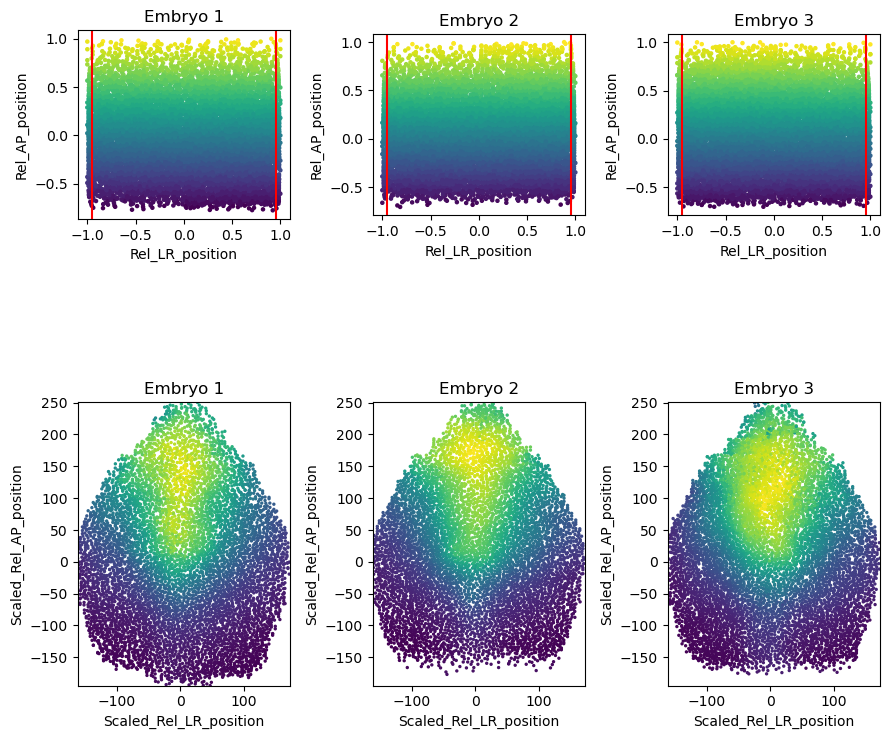

In [49]:
#Choose the column to use for the AP axis
y_col = 'Rel_AP_position'

# Left-right limits
LR_limits = 0.95

# Binning
binsize = 0.05
bins = np.arange(all_cells[y_col].min(), all_cells[y_col].max(), binsize)
all_cells['binned'] = np.digitize(all_cells[y_col], bins)

epi_nuc_mask = (all_cells['Epiblast'] >= 0)

l_means, r_means = compute_mean_edge_position(all_cells, 
                                              epi_nuc_mask,
                                              embryo_id = 'embryo',
                                              LR_col = 'AVLR',
                                               LR_limit = LR_limits)


# scale left and right values to the mean values per bin
all_cells.loc[(all_cells['Rel_LR_position'] > 0)& epi_nuc_mask, 'mean_Abss'] = all_cells.loc[(all_cells['Rel_LR_position'] > 0) & epi_nuc_mask, 'binned'].map(l_means['mean_Abss'])
all_cells.loc[(all_cells['Rel_LR_position'] < 0)& epi_nuc_mask, 'mean_Abss'] = all_cells.loc[(all_cells['Rel_LR_position'] < 0) & epi_nuc_mask, 'binned'].map(r_means['mean_Abss'])

# Scale the values by the threshold
all_cells['Scaled_Rel_LR_position'] = all_cells['mean_Abss'] * abs(all_cells['Rel_LR_position'])

#Divide by the threshold to account for loss of distance
all_cells['Scaled_Rel_LR_position'] = all_cells['Scaled_Rel_LR_position'] / LR_limits


fig, ax = plt.subplots(2, len(all_cells['embryo'].unique()), figsize=(9, 9))
for idx, embryo in enumerate(all_cells['embryo'].unique()):
    temp = all_cells[(all_cells['embryo'] == embryo) & (all_cells['Epiblast'] >= 0)]
    ax[0,idx].scatter(temp['Rel_LR_position'], temp[y_col], c=temp['binned'], s=5)
    ax[0,idx].set_title(f'Embryo {embryo}') 
    ax[0,idx].set_xlabel('Rel_LR_position')
    ax[0,idx].set_ylabel('Rel_AP_position')
    ax[0,idx].set_aspect('equal')

    #show thresholda
    ax[0,idx].axvline(x=LR_limits, color='r')
    ax[0,idx].axvline(x=-LR_limits, color='r')

    ax[1, idx].scatter(temp['Scaled_Rel_LR_position'], temp['Scaled_Rel_AP_position'], c=temp[smth_midline_channel], s=2)
    ax[1, idx].set_title(f'Embryo {embryo}')
    ax[1, idx].set_xlabel('Scaled_Rel_LR_position')
    ax[1, idx].set_ylabel('Scaled_Rel_AP_position')
    ax[1, idx].set_aspect('equal')

    #enforce limits from whole dataset
    xlim = all_cells['Scaled_Rel_LR_position'].min(), all_cells['Scaled_Rel_LR_position'].max()
    ylim = all_cells['Scaled_Rel_AP_position'].min(), all_cells['Scaled_Rel_AP_position'].max()

    ax[1, idx].set_xlim(xlim)
    ax[1, idx].set_ylim(ylim)
    
plt.tight_layout()
plt.show()

#### Before and after PRINGLE #glowup

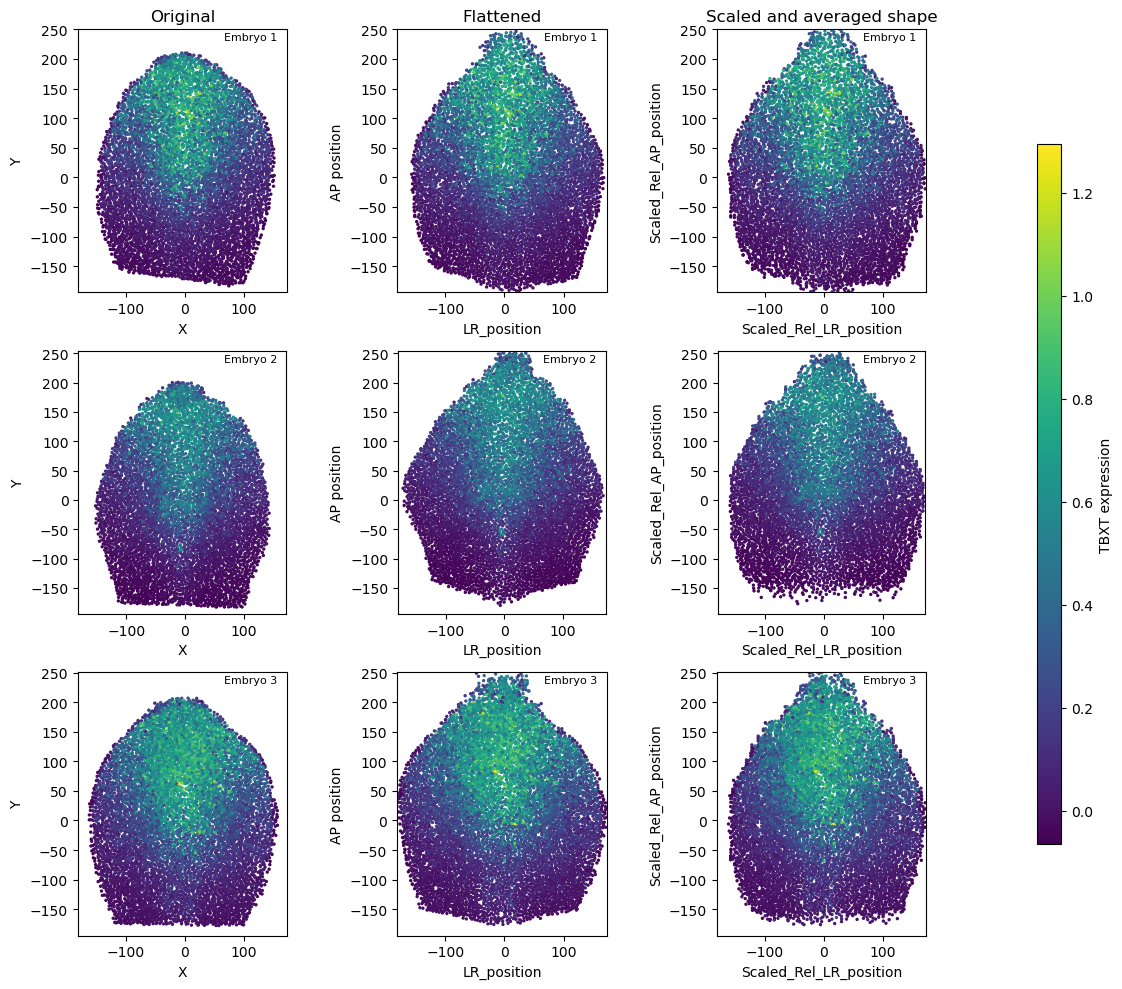

In [50]:
fig, ax = plt.subplots(len(all_cells['embryo'].unique()), 3, figsize=(12, 10))

# Create a placeholder for the scatter plot to use in colorbar
sc = None  

for idx, embryo in enumerate(all_cells['embryo'].unique()):
    temp = all_cells[(all_cells['embryo'] == embryo) & (all_cells['Epiblast'] >= 0)]
    noto_point = noto_starts[noto_starts['embryo'] == embryo]

    AP_pos_rel_noto = temp['AP_position'] - noto_point['AP_position'].values[0]

    # Store scatter plot in 'sc' for colorbar reference
    sc = ax[idx, 0].scatter(temp['Oriented_Y'], -temp['Oriented_X'], c=temp[midline_channel], s=2)
    ax[idx, 0].set_xlabel('X')
    ax[idx, 0].set_ylabel('Y')
    ax[idx, 0].set_aspect('equal')
    ax[idx, 0].text(0.7, 0.99, f'Embryo {embryo}', transform=ax[idx, 0].transAxes, fontsize=8, verticalalignment='top')

    ax[idx, 1].scatter(temp['AVLR'], -AP_pos_rel_noto, c=temp[midline_channel], s=2)
    ax[idx, 1].set_xlabel('LR_position')
    ax[idx, 1].set_ylabel('AP position')
    ax[idx, 1].set_aspect('equal')
    ax[idx, 1].text(0.7, 0.99, f'Embryo {embryo}', transform=ax[idx, 1].transAxes, fontsize=8, verticalalignment='top')

    ax[idx, 2].scatter(temp['Scaled_Rel_LR_position'], temp['Scaled_Rel_AP_position'], c=temp[midline_channel], s=2)
    ax[idx, 2].set_xlabel('Scaled_Rel_LR_position')
    ax[idx, 2].set_ylabel('Scaled_Rel_AP_position')
    ax[idx, 2].set_aspect('equal')
    ax[idx, 2].text(0.7, 0.99, f'Embryo {embryo}', transform=ax[idx, 2].transAxes, fontsize=8, verticalalignment='top')

    # Enforce limits from whole dataset
    xlim = min(all_cells['Scaled_Rel_LR_position'].min(), all_cells['AVLR'].min()), max(all_cells['Scaled_Rel_LR_position'].max(), all_cells['AVLR'].max())
    ylim = min(all_cells['Scaled_Rel_AP_position'].min(), (-AP_pos_rel_noto).min()), max(all_cells['Scaled_Rel_AP_position'].max(), (-AP_pos_rel_noto).max())

    ax[idx, 2].set_xlim(xlim)
    ax[idx, 2].set_ylim(ylim)
    ax[idx, 1].set_xlim(xlim)
    ax[idx, 1].set_ylim(ylim)
    ax[idx, 0].set_xlim(xlim)
    ax[idx, 0].set_ylim(ylim)

# Set titles for columns
ax[0, 0].set_title('Original')
ax[0, 1].set_title('Flattened')
ax[0, 2].set_title('Scaled and averaged shape')

# Adjust layout to avoid colorbar overlap
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Leave space on the right for colorbar

# Add a single colorbar on the right without overlaying plots
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(sc, cax=cbar_ax)
cbar.set_label('TBXT expression')

plt.show()


In [51]:
# Save progress and smoothed line
all_cells.to_csv(os.path.join(mouse_demo_dir, 'Data', 'mouse_data_processing.csv'), index=False)
